In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf

import math
import FinanceDataReader as fdr

In [2]:
tf.reset_default_graph() 

AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

In [ ]:
# 표준화
def data_standardization(x):
    x_np = np.asarray(x)
    return (x_np - x_np.mean()) / x_np.std()
 
# 너무 작거나 너무 큰 값이 학습을 방해하는 것을 방지하고자 정규화한다
# x가 양수라는 가정하에 최소값과 최대값을 이용하여 0~1사이의 값으로 변환
# Min-Max scaling
def min_max_scaling(x):
    x_np = np.asarray(x)
    return (x_np - x_np.min()) / (x_np.max() - x_np.min() + 1e-7) # 1e-7은 0으로 나누는 오류 예방차원
 
# 정규화된 값을 원래의 값으로 되돌린다
# 정규화하기 이전의 org_x값과 되돌리고 싶은 x를 입력하면 역정규화된 값을 리턴한다
def reverse_min_max_scaling(org_x, x):
    org_x_np = np.asarray(org_x)
    x_np = np.asarray(x)
    return (x_np * (org_x_np.max() - org_x_np.min() + 1e-7)) + org_x_np.min()

In [ ]:
# 하이퍼파라미터
input_data_column_cnt = 5  # 입력데이터의 컬럼 개수(Variable 개수)
output_data_column_cnt = 1 # 결과데이터의 컬럼 개수

seq_length = 28            # 1개 시퀀스의 길이(시계열데이터 입력 개수)
rnn_cell_hidden_dim = 20   # 각 셀의 (hidden)출력 크기
forget_bias = 1.0          # 망각편향(기본값 1.0)
num_stacked_layers = 1     # stacked LSTM layers 개수
keep_prob = 1.0            # dropout할 때 keep할 비율

epoch_num = 1000           # 에폭 횟수(학습용전체데이터를 몇 회 반복해서 학습할 것인가 입력)
learning_rate = 0.01       # 학습률 (적당히 설정해놔야됨 여기서 적당히란...? )

In [ ]:
data = fdr.DataReader('005930','2000-01-04','')

In [ ]:
stock_info = data.values[:].astype(np.float) # 금액&거래량 문자열을 부동소수점형으로 변환한다
print("stock_info.shape: ", stock_info.shape)
print("stock_info[0]: ", stock_info[0])
print('date 값 삭제 후 rea_dateframe.info')
data.info() 

stock_info.shape:  (5635, 6)
stock_info[0]:  [6.00000000e+03 6.11000000e+03 5.66000000e+03 6.11000000e+03
 1.48396700e+06 1.48496241e-01]
date 값 삭제 후 rea_dateframe.info
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5635 entries, 2000-01-04 to 2022-10-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5635 non-null   int64  
 1   High    5635 non-null   int64  
 2   Low     5635 non-null   int64  
 3   Close   5635 non-null   int64  
 4   Volume  5635 non-null   int64  
 5   Change  5635 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 308.2 KB


C:\Users\thrry\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


# 정규화
## 사용할 데이터
 가격
 거래량


In [ ]:
price = stock_info[:,:-2] # 시작가, 최고가, 최저가, 종료가
norm_price = min_max_scaling(price) # 가격형태 데이터 정규화 처리

In [ ]:
# 거래량형태 데이터를 정규화한다
# ['Open','High','Low','Close','Adj Close','Volume']에서 마지막 'Volume'만 취함
# [:,-1]이 아닌 [:,-1:]이므로 주의하자! 스칼라가아닌 벡터값 산출해야만 쉽게 병합 가능
volume = stock_info[:,-2:-1]
norm_volume = min_max_scaling(volume) # 거래량형태 데이터 정규화 처리
print("volume.shape: ", volume.shape)
print("volume[0]: ", volume[0])
print("norm_volume[0]: ", norm_volume[0])
print("="*100) # 화면상 구분용

volume.shape:  (5635, 1)
volume[0]:  [1483967.]
norm_volume[0]:  [0.01643262]


In [ ]:
# 행은 그대로 두고 열을 우측에 붙여 합친다
x = np.concatenate((norm_price, norm_volume), axis=1) # axis=1, 세로로 합친다
print("x.shape: ", x.shape)
print("x[0]: ", x[0])    # x의 첫 값
print("x[-1]: ", x[-1])  # x의 마지막 값
print("="*100) 

x.shape:  (5635, 5)
x[0]:  [0.06198347 0.06311983 0.05847107 0.06311983 0.01643262]
x[-1]:  [0.60020661 0.61880165 0.59917355 0.61673554 0.14725642]


In [ ]:
y = x[:, [-2]] # 타켓은 주식 종가이다
print("y[0]: ",y[0])     # y의 첫 값
print("y[-1]: ",y[-1])   # y의 마지막 값

y[0]:  [0.06311983]
y[-1]:  [0.61673554]


In [ ]:
dataX = [] # 입력으로 사용될 Sequence Data
dataY = [] # 출력(타켓)으로 사용

for i in range(0, len(y) - seq_length):
    _x = x[i : i+seq_length]
    _y = y[i + seq_length] # 다음 나타날 주가(정답)
    if i is 0:
        print(_x, "->", _y) # 첫번째 행만 출력해 봄
    dataX.append(_x) # dataX 리스트에 추가
    dataY.append(_y) # dataY 리스트에 추가

[[0.06198347 0.06311983 0.05847107 0.06311983 0.01643262]
 [0.05991736 0.06260331 0.05702479 0.05764463 0.01653933]
 [0.05940083 0.05971074 0.05764463 0.05805785 0.0120458 ]
 [0.05743802 0.05857438 0.0553719  0.0572314  0.00892735]
 [0.05785124 0.05960744 0.05764463 0.05960744 0.01038262]
 [0.06012397 0.06301653 0.05960744 0.05960744 0.01323247]
 [0.05795455 0.05929752 0.05785124 0.05909091 0.00647234]
 [0.05785124 0.05929752 0.05743802 0.0589876  0.00912263]
 [0.05909091 0.0607438  0.05867769 0.06022727 0.01093586]
 [0.06198347 0.06384298 0.06115702 0.06301653 0.0140648 ]
 [0.06363636 0.06363636 0.06177686 0.06301653 0.01002402]
 [0.06198347 0.06239669 0.06157025 0.06157025 0.00890481]
 [0.06053719 0.06239669 0.06012397 0.06239669 0.00826477]
 [0.06146694 0.06177686 0.0607438  0.0607438  0.0072058 ]
 [0.05991736 0.06095041 0.0588843  0.0588843  0.00760948]
 [0.05702479 0.05826446 0.05619835 0.05619835 0.00980074]
 [0.05681818 0.05702479 0.05588843 0.05661157 0.00648609]
 [0.05661157 0

In [ ]:
# 학습용/테스트용 데이터 생성
# 전체 70%를 학습용 데이터로 사용
train_size = int(len(dataY) * 0.7)

# 나머지(30%)를 테스트용 데이터로 사용
test_size = len(dataY) - train_size

# 데이터를 잘라 학습용 데이터 생성
trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])

# 데이터를 잘라 테스트용 데이터 생성
testX = np.array(dataX[train_size:len(dataX)])
testY = np.array(dataY[train_size:len(dataY)])

In [ ]:
# 텐서플로우 플레이스홀더 생성
# 입력 X, 출력 Y를 생성한다

X = tf.placeholder(tf.float32, [None, seq_length, input_data_column_cnt])
print("X: ", X)
Y = tf.placeholder(tf.float32, [None, 1])
print("Y: ", Y)

# 검증용 측정지표를 산출하기 위한 targets, predictions를 생성한다
targets = tf.placeholder(tf.float32, [None, 1])
print("targets: ", targets)

predictions = tf.placeholder(tf.float32, [None, 1])
print("predictions: ", predictions)


X:  Tensor("Placeholder:0", shape=(?, 28, 5), dtype=float32)
Y:  Tensor("Placeholder_1:0", shape=(?, 1), dtype=float32)
targets:  Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
predictions:  Tensor("Placeholder_3:0", shape=(?, 1), dtype=float32)


In [ ]:
# 모델(LSTM 네트워크) 생성
def lstm_cell():
    # LSTM셀을 생성
    # num_units: 각 Cell 출력 크기
    # forget_bias:  to the biases of the forget gate 
    #              (default: 1)  in order to reduce the scale of forgetting in the beginning of the training.
    # state_is_tuple: True ==> accepted and returned states are 2-tuples of the c_state and m_state.
    # state_is_tuple: False ==> they are concatenated along the column axis.
    cell = tf.contrib.rnn.BasicLSTMCell(num_units=rnn_cell_hidden_dim, 
    
                                        forget_bias=forget_bias, state_is_tuple=True, activation=tf.nn.leaky_relu)
    if keep_prob < 1.0:
        cell = tf.contrib.rnn.DropoutWrapper(cell, output_keep_prob=keep_prob)
    return cell

# num_stacked_layers개의 층으로 쌓인 Stacked RNNs 생성
stackedRNNs = [lstm_cell() for _ in range(num_stacked_layers)]
multi_cells = tf.contrib.rnn.MultiRNNCell(stackedRNNs, state_is_tuple=True) if num_stacked_layers > 1 else lstm_cell()

# RNN Cell(여기서는 LSTM셀임)들을 연결
hypothesis, _states = tf.nn.dynamic_rnn(multi_cells, X, dtype=tf.float32)
print("hypothesis: ", hypothesis)

# [:, -1]를 잘 살펴보자. LSTM RNN의 마지막 (hidden)출력만을 사용했다.
# 과거 여러 거래일의 주가를 이용해서 다음날의 주가 1개를 예측하기때문에 MANY-TO-ONE형태이다
hypothesis = tf.contrib.layers.fully_connected(hypothesis[:, -1], output_data_column_cnt, activation_fn=tf.identity)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
hypothesis:  Tensor("rnn/transpose_1:0", shape=(?, 28, 20), dtype=float32)
Instructions for updating:
Please use `layer.__call__` method instead.


In [ ]:
# 손실함수로 평균제곱오차를 사용한다
loss = tf.reduce_sum(tf.square(hypothesis - Y))
# 최적화함수로 AdamOptimizer를 사용한다
optimizer = tf.train.AdamOptimizer(learning_rate)
# optimizer = tf.train.RMSPropOptimizer(learning_rate) # LSTM과 궁합 별로임

train = optimizer.minimize(loss)

# RMSE(Root Mean Square Error)
# 제곱오차의 평균을 구하고 다시 제곱근을 구하면 평균 오차가 나온다
# rmse = tf.sqrt(tf.reduce_mean(tf.square(targets-predictions))) # 아래 코드와 같다
rmse = tf.sqrt(tf.reduce_mean(tf.squared_difference(targets, predictions)))

In [ ]:
train_error_summary = [] # 학습용 데이터의 오류를 중간 중간 기록한다
test_error_summary = []  # 테스트용 데이터의 오류를 중간 중간 기록한다
test_predict = ''        # 테스트용데이터로 예측한 결과

sess = tf.Session()
sess.run(tf.global_variables_initializer())

# 학습한다
start_time = datetime.datetime.now() # 시작시간을 기록한다
print('학습을 시작합니다...')
for epoch in range(epoch_num):
    _, _loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
    if ((epoch+1) % 100 == 0) or (epoch == epoch_num-1): # 100번째마다 또는 마지막 epoch인 경우
        # 학습용데이터로 rmse오차를 구한다
        train_predict = sess.run(hypothesis, feed_dict={X: trainX})
        train_error = sess.run(rmse, feed_dict={targets: trainY, predictions: train_predict})
        train_error_summary.append(train_error)

        # 테스트용데이터로 rmse오차를 구한다
        test_predict = sess.run(hypothesis, feed_dict={X: testX})
        test_error = sess.run(rmse, feed_dict={targets: testY, predictions: test_predict})
        test_error_summary.append(test_error)
        
        # 현재 오류를 출력한다
        print("epoch: {}, train_error(A): {}, test_error(B): {}, B-A: {}".format(epoch+1, train_error, test_error, test_error-train_error))
        
end_time = datetime.datetime.now() # 종료시간을 기록한다
elapsed_time = end_time - start_time # 경과시간을 구한다
print('elapsed_time:',elapsed_time)
print('elapsed_time per epoch:',elapsed_time/epoch_num)



학습을 시작합니다...
epoch: 100, train_error(A): 0.004760114476084709, test_error(B): 0.10281622409820557, B-A: 0.09805610775947571
epoch: 200, train_error(A): 0.004372624680399895, test_error(B): 0.06722041964530945, B-A: 0.0628477931022644
epoch: 300, train_error(A): 0.004298937972635031, test_error(B): 0.053204141557216644, B-A: 0.048905204981565475
epoch: 400, train_error(A): 0.004244101699441671, test_error(B): 0.0433025062084198, B-A: 0.03905840590596199
epoch: 500, train_error(A): 0.004198043141514063, test_error(B): 0.036929573863744736, B-A: 0.03273152932524681
epoch: 600, train_error(A): 0.004154292866587639, test_error(B): 0.03298666700720787, B-A: 0.02883237414062023
epoch: 700, train_error(A): 0.004110376816242933, test_error(B): 0.030850326642394066, B-A: 0.026739949360489845
epoch: 800, train_error(A): 0.004065423738211393, test_error(B): 0.02933463081717491, B-A: 0.02526920661330223
epoch: 900, train_error(A): 0.004019665066152811, test_error(B): 0.027875781059265137, B-A: 0.

input_data_column_cnt: 5,output_data_column_cnt: 1,seq_length: 28,rnn_cell_hidden_dim: 20,forget_bias: 1.0,num_stacked_layers: 1,keep_prob: 1.0,epoch_num: 1000,learning_rate: 0.01,train_error: 0.0039734785,test_error: 0.026368005,min_test_error: 0.026368005


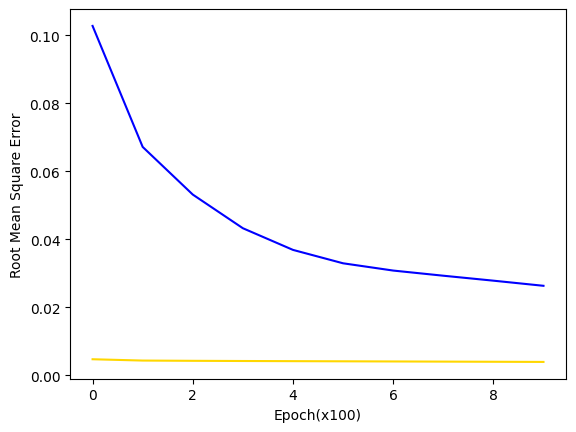

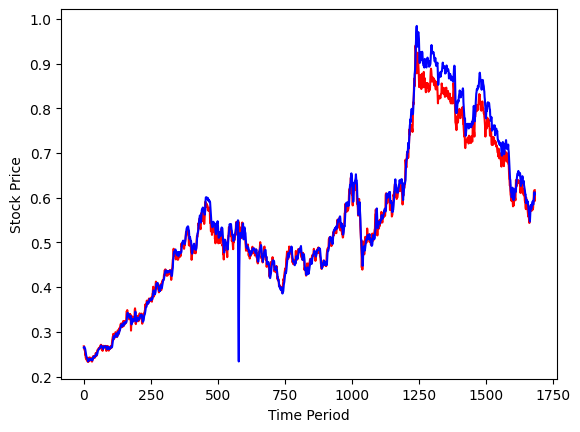

Text(0, 0.5, 'Root Mean Square Error')

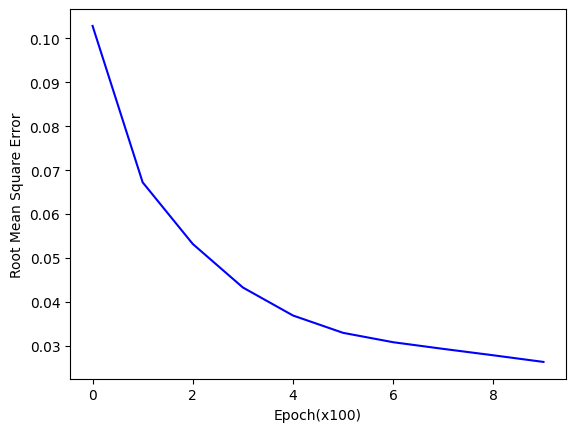

In [ ]:
# 하이퍼파라미터 출력
print('input_data_column_cnt:', input_data_column_cnt, end='')
print(',output_data_column_cnt:', output_data_column_cnt, end='')

print(',seq_length:', seq_length, end='')
print(',rnn_cell_hidden_dim:', rnn_cell_hidden_dim, end='')
print(',forget_bias:', forget_bias, end='')
print(',num_stacked_layers:', num_stacked_layers, end='')
print(',keep_prob:', keep_prob, end='')

print(',epoch_num:', epoch_num, end='')
print(',learning_rate:', learning_rate, end='')

print(',train_error:', train_error_summary[-1], end='')
print(',test_error:', test_error_summary[-1], end='')
print(',min_test_error:', np.min(test_error_summary))

# 결과 그래프 출력
plt.figure(1)
plt.plot(train_error_summary, 'gold')
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')

plt.figure(2)
plt.plot(testY, 'r')
plt.plot(test_predict, 'b')
plt.xlabel('Time Period')
plt.ylabel('Stock Price')
plt.show()

plt.figure(3)
plt.plot(test_error_summary, 'b')
plt.xlabel('Epoch(x100)')
plt.ylabel('Root Mean Square Error')

In [ ]:
# sequence length만큼의 가장 최근 데이터를 슬라이싱한다
recent_data = np.array([x[len(x)-seq_length : ]])
print("recent_data.shape:", recent_data.shape)
print("recent_data:", recent_data)

# 내일 종가를 예측해본다
test_predict = sess.run(hypothesis, feed_dict={X: recent_data})

print("test_predict", test_predict[0])
test_predict = reverse_min_max_scaling(price,test_predict) # 금액데이터 역정규화한다
print("Tomorrow's stock price", test_predict[0]) # 예측한 주가를 출력한다

recent_data.shape: (1, 28, 5)
recent_data: [[[0.58264463 0.58884298 0.57644628 0.57644628 0.15548732]
  [0.57231405 0.57334711 0.56818182 0.57128099 0.13137197]
  [0.56404959 0.56508264 0.56095041 0.56198347 0.14159065]
  [0.56198347 0.56714876 0.55991736 0.56301653 0.11689083]
  [0.55475207 0.55991736 0.55371901 0.55681818 0.16619515]
  [0.55578512 0.55991736 0.55268595 0.55991736 0.18416557]
  [0.55681818 0.56198347 0.54235537 0.5464876  0.22137056]
  [0.55061983 0.55475207 0.54338843 0.54338843 0.15372237]
  [0.54028926 0.55371901 0.53512397 0.54855372 0.24918837]
  [0.57128099 0.57231405 0.56301653 0.57024793 0.21203904]
  [0.58780992 0.59090909 0.57231405 0.5785124  0.24869805]
  [0.5857438  0.59194215 0.58161157 0.58161157 0.16548642]
  [0.57747934 0.58780992 0.57024793 0.58057851 0.1869951 ]
  [0.56198347 0.57541322 0.55785124 0.57231405 0.23739104]
  [0.57541322 0.58884298 0.57024793 0.57644628 0.20384995]
  [0.57231405 0.57954545 0.57024793 0.57024793 0.15264296]
  [0.58057851